In [1]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
import utils
from torchkbnufft.modules.kbnufft import KbNufft as NUFFT_Forward_OP
from torchkbnufft.modules.kbnufft import KbNufftAdjoint as NUFFT_Adjoint_OP
from tqdm.auto import tqdm

In [22]:
class Lab07_op:

    def __init__(self):
        self.PI = np.pi

        # For NUFFT operator
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def load_data(self):
        mat = utils.load_data("data_radial_brain_4ch.mat")
        kspace = mat["kdata"]
        sens_maps = mat["c"]
        traj = mat["k"]  # range of traj: -0.5~0.5
        dc_weights = mat["w"]
        gt = mat["img_senscomb"]

        return kspace, sens_maps, traj, dc_weights, gt

    def get_nufft_ob(self, im_size: Tuple[int, int], grid_size: Tuple[int, int]) -> tkbn.KbNufft:
        """
        Define a NUFFT operator with the given parameters.

        Args:
            im_size:            Size of image with length being the number of dimensions.
            grid_size:          Size of grid to use for interpolation,
                                typically 1.25 to 2 times ``im_size``.

        Returns:
            nufft_ob:           NUFFT operator
        """
        # Your code here ...
        nufft_ob = tkbn.KbNufft(im_size=im_size,grid_size=grid_size)
        return nufft_ob

    def get_nufft_adj_ob(self, im_size: Tuple[int, int], grid_size: Tuple[int, int]) -> tkbn.KbNufftAdjoint:
        """
        Define a adjoint NUFFT operator with the given parameters.
        Don't forget to set the device to self.device.


        Args:
            im_size:            Size of image with length being the number of dimensions.
            grid_size:          Size of grid to use for interpolation,
                                typically 1.25 to 2 times ``im_size``.

        Returns:
            nufft_adj_ob:       Adjoint NUFFT operator
        """
        # Your code here ...
        nufft_adj_ob = tkbn.KbNufftAdjoint(im_size=im_size,grid_size=grid_size)
        return nufft_adj_ob
    
    def get_nufft_kdata(self, kdata: np.ndarray, dc_weights: Optional[np.ndarray] = None) -> torch.Tensor:
        """
        This method converts the k-space data to the format that NUFFT operator can use.
        Don't forget to set the device to self.device.

        Args:
            kdata: k-space data. (shape of [Readout, Spokes, Channels])
            dc_weights: [Optional] Density compensation weights. When dc_weights is given, apply it to kdata. (shape of [Readout, Spokes])

        Returns:
            kdata_nufft: k-space data in the format that NUFFT operator can use. (shape of [Batch(1), Channels, Readout*Spokes])
        """
        kdata_nufft = kdata.copy()

        # Your code here ...
        n_ro, n_spokes, n_channel = np.shape(kdata)
        kdata_nufft_temp = np.zeros([1,n_channel,n_ro*n_spokes],dtype=complex)

        if dc_weights is not None:
            for i in range(n_channel):
                kdata_nufft[:,:,i] *= dc_weights 

        for i in range(n_channel):
            kdata_nufft_temp[0,i,:] = np.reshape(kdata_nufft[:,:,i],(1,n_ro*n_spokes))        

        kdata_nufft = torch.tensor(kdata_nufft_temp,dtype=torch.complex128, device=self.device)  ########################complex128
        return kdata_nufft

    def get_nufft_traj(self, traj: np.ndarray) -> torch.Tensor:
        """
        This method converts the trajectory to the format that NUFFT operator can use.
        traj in the provided .mat file is in the range of [-0.5 ~ 0.5], while NUFFT operator requires the range of [-PI ~ PI].
        Don't forget to set the device to self.device.

        Args:
            traj: Trajectory of the k-space data. (shape of [Readout, Spokes])

        Returns:
            traj_stack: Trajectory of the k-space data in the format that NUFFT operator can use. (shape of [2, Readout*Spokes], two channels for real and imaginary parts)
        """
        # Your code here ...

        # To make the range of traj to [-PI ~ PI]
        r, s = np.shape(traj)
        traj_nufft = traj * 2* self.PI
        real = np.real(np.reshape(traj_nufft,(1,r*s)))
        imag = np.imag(np.reshape(traj_nufft,(1,r*s)))
        traj_stack = np.stack((real.flatten(),imag.flatten()),axis=0)

        return torch.tensor(traj_stack, dtype=torch.float32, device=self.device) #########################complex128
    
    def get_nufft_sens_maps(self, sens_maps: np.ndarray) -> torch.Tensor:
        """
        This method converts the sensitivity maps to the format that NUFFT operator can use.
        Don't forget to set the device to self.device.

        Args:
            sens_maps: Sensitivity maps of the k-space data. (shape of [Readout//2, Readout // 2, Channels])

        Returns:
            sens_maps_nufft: Sensitivity maps of the k-space data in the format that NUFFT operator can use. (shape of [Batch(1), Channels, Readout // 2, Readout // 2])
        """
        # Your code here ...
        m,n,n_channel = np.shape(sens_maps)
        sens_maps_nufft = np.zeros([1,n_channel,m,n],dtype=complex)
        for i in range(n_channel):
            sens_maps_nufft[:,i,:,:] = sens_maps[:,:,i]

        return torch.tensor(sens_maps_nufft,dtype=torch.complex128,device=self.device)
    

    def nufft_recon(
        self,
        kdata: np.ndarray,
        traj: np.ndarray,
        sens_maps: np.ndarray,
        dc_weights: np.ndarray,
        **kwargs,
    ) -> np.ndarray:
        """
        This method reconstructs the image from the k-space data using the NUFFT operator.
        Apply the dc_weights to kdata.
        Reconstruction is done by the adjoint NUFFT operator with orthonormal normalization.

        Args:
            kdata: k-space data. (shape of [Readout, Spokes, Channels])
            traj: Trajectory of the k-space data. (shape of [Readout, Spokes])
            sens_maps: Sensitivity maps of the k-space data. (shape of [Readout//2, Readout // 2, Channels])
            dc_weights: Density compensation weights. (shape of [Readout, Spokes])

        Returns:
            recon_NUFFT: Reconstructed image from the k-space data using the NUFFT operator. (absolute valued np.ndarray, shape of [Readout // 2, Readout // 2])
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_nufft_adj_ob = kwargs.get("get_nufft_adj_ob", self.get_nufft_adj_ob)
        get_nufft_traj = kwargs.get("get_nufft_traj", self.get_nufft_traj)
        get_nufft_sens_maps = kwargs.get("get_nufft_sens_maps", self.get_nufft_sens_maps)
        get_nufft_kdata = kwargs.get("get_nufft_kdata", self.get_nufft_kdata)

        # Your code here ...
        im_size = np.shape(sens_maps[:,:,0])
        grid_size = [np.shape(kdata)[0], np.shape(kdata)[0]]

        nufft_adj_ob = self.get_nufft_adj_ob(im_size,grid_size)

        nufft_kdata = self.get_nufft_kdata(kdata=kdata,dc_weights=dc_weights)
        nufft_traj = self.get_nufft_traj(traj)
        nufft_sm = self.get_nufft_sens_maps(sens_maps)

        #print(np.shape(nufft_kdata),np.shape(nufft_traj),np.shape(nufft_sm))

        # Reconstruction
        recon_NUFFT_temp = nufft_adj_ob(data=nufft_kdata,omega=nufft_traj,smaps=nufft_sm,norm="ortho")
        # recon_NUFFT_temp = recon_NUFFT_temp.numpy()
        # recon_NUFFT = recon_NUFFT_temp[0,0,:,:]
        # return np.abs(recon_NUFFT)
        return np.abs(recon_NUFFT_temp.squeeze().numpy()) 
    

    def calc_grad(
        self,
        nufft_ob: NUFFT_Forward_OP,
        nufft_adj_ob: NUFFT_Adjoint_OP,
        nufft_traj: torch.Tensor,
        nufft_sm: torch.Tensor,
        u: torch.Tensor,
        g: torch.Tensor,
    ) -> torch.Tensor:
        """
        This method calculates the gradient of the objective function for the NUFFT operator.
        Preserve energy by using the orthonormal normalization between transforms.

        Args:
            nufft_ob: NUFFT operator
            nufft_adj_ob: Adjoint NUFFT operator
            nufft_traj: Trajectory of the k-space data for NUFFT operator. (shape of [2, Readout*Spokes])
            nufft_sm: Sensitivity maps of the k-space data for NUFFT operator. (shape of [Batch(1), Channels, Readout // 2, Readout // 2])
            u: Image to be reconstructed. (shape of [Batch(1), Channels, Readout // 2, Readout // 2])
            g: k-space data. (shape of [Batch(1), Channels, Readout*Spokes])

        Returns:
            grad: Gradient of the objective function for the NUFFT operator. (shape of [Batch(1), Channels, Readout // 2, Readout // 2])
        """
        # Your code here ...
        t1 = nufft_ob(u,nufft_traj,smaps=nufft_sm,norm="ortho") - g
        grad = 2 * nufft_adj_ob(t1,nufft_traj,smaps=nufft_sm,norm="ortho")

        return grad
    
    def nufft_gd_recon(
        self,
        gt: np.ndarray,
        kdata: np.ndarray,
        traj: np.ndarray,
        sens_maps: np.ndarray,
        iter: Optional[int] = 100,
        step_size: Optional[int] = 0.01,
        **kwargs,
    ) -> Tuple[list, list, list]:
        """
        This method reconstructs the image from the k-space data using the NUFFT operator with the gradient descent method.
        See the lecture note p.15 for the gradient descent algorithm.

        Args:
            gt: Ground truth image to calculate RMSE. (shape of [Readout // 2, Readout // 2])
            kdata: k-space data. (shape of [Readout, Spokes, Channels])
            traj: Trajectory of the k-space data. (shape of [Readout, Spokes])
            sens_maps: Sensitivity maps of the k-space data. (shape of [Readout//2, Readout // 2, Channels])
            iter: Number of iterations for the gradient descent method. Default: 100
            step_size: Step size for the gradient descent method. Default: 0.01

        Returns:
            recons_gd: Reconstructed images from the k-space data using the NUFFT operator with the gradient descent method. (List of absolute valued np.ndarray, shape of [Readout // 2, Readout // 2])
            nmse_gd: Normalized mean squared error of the reconstructed images at each iteration. (shape of [iter])
            grad_norms: L2 norm of the gradient at each iteration. (shape of [iter])
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_nufft_ob = kwargs.get("get_nufft_ob", self.get_nufft_ob)
        get_nufft_adj_ob = kwargs.get("get_nufft_adj_ob", self.get_nufft_adj_ob)
        get_nufft_traj = kwargs.get("get_nufft_traj", self.get_nufft_traj)
        get_nufft_sens_maps = kwargs.get("get_nufft_sens_maps", self.get_nufft_sens_maps)
        get_nufft_kdata = kwargs.get("get_nufft_kdata", self.get_nufft_kdata)
        calc_grad = kwargs.get("calc_grad", self.calc_grad)

        # Your code here ...
        N_ro, *_ = kdata.shape
        im_size = (N_ro // 2, N_ro // 2)
        grid_size = (N_ro, N_ro)

        nufft_ob = self.get_nufft_ob(im_size,grid_size)
        nufft_adj_ob = self.get_nufft_adj_ob(im_size,grid_size)

        nufft_traj = self.get_nufft_traj(traj)
        nufft_sm = self.get_nufft_sens_maps(sens_maps)

        u = torch.tensor(np.zeros([1,1,im_size[0],im_size[1]]),dtype=torch.complex128,device=self.device)
        g = self.get_nufft_kdata(kdata)

        nmse_gd = []
        grad_norms = []
        recons_gd = []
        with tqdm(total=iter, unit="iter", leave=True) as pbar:
            for ii in range(iter):
                grad = self.calc_grad(nufft_ob,nufft_adj_ob,nufft_traj,nufft_sm,u,g)
                u = u - step_size * grad

                grad_norm = torch.norm(grad)
                abs_u = np.abs(u.squeeze().numpy())
                nmse_gd.append(utils.calc_nmse(np.abs(gt), abs_u))
                grad_norms.append(grad_norm)

                pbar.set_description(desc=f"Iteration {ii: 3d}")
                pbar.set_postfix({"L2 norm": f"{grad_norm: .5f}"})
                pbar.update()
                recons_gd.append(abs_u)

        return recons_gd, nmse_gd, grad_norms
    
    def nufft_cg(
        self,
        nufft_ob: NUFFT_Forward_OP,
        nufft_adj_ob: NUFFT_Adjoint_OP,
        nufft_kdata: torch.Tensor,
        nufft_traj: torch.Tensor,
        nufft_sm: torch.Tensor,
        im_size: tuple,
        iter: int,
        tol: float,
        gt: Optional[np.ndarray] = None,
    ) -> Tuple[np.ndarray, list, list]:
        """
        Conjugate Gradient method using NUFFT operator for non-Cartesian k-space data.
        Preserve energy by using the orthonormal normalization between transforms.
        See the Appendix 1 in the exercise description for the conjugate gradient algorithm.

        Args:
            nufft_ob: NUFFT operator
            nufft_adj_ob: Adjoint NUFFT operator
            nufft_kdata: k-space data in the format that NUFFT operator can use. (shape of [Batch(1), Channels, Readout*Spokes])
            nufft_traj: Trajectory of the k-space data for NUFFT operator. (shape of [2, Readout*Spokes])
            nufft_sm: Sensitivity maps of the k-space data for NUFFT operator. (shape of [Batch(1), Channels, Readout // 2, Readout // 2])
            im_size: Size of image with length being the number of dimensions.
            iter: Number of iterations for the conjugate gradient method.
            tol: Tolerance for the residual norm to stop the iteration.
            gt: Ground truth image to calculate RMSE. (shape of [Readout // 2, Readout // 2])

        Returns:
            x_np: Reconstructed image from the k-space data using the NUFFT operator with the conjugate gradient method. (absolute valued np.ndarray, shape of [Readout // 2, Readout // 2])
            gifs: List of reconstructed images at each iteration. (List of absolute valued np.ndarray, shape of [Readout // 2, Readout // 2])
            nmse: Normalized mean squared error of the reconstructed images at each iteration. (shape of [iter])
        """
        # Your code here ...
        x = torch.tensor(np.zeros([1,1,im_size[0],im_size[1]]),dtype=torch.complex128,device=self.device)
        r = nufft_adj_ob(nufft_kdata,nufft_traj,smaps=nufft_sm,norm="ortho")-nufft_adj_ob(nufft_ob(x,nufft_traj,smaps=nufft_sm,norm="ortho"),nufft_traj,smaps=nufft_sm,norm="ortho")
        p = r.clone()
        rt_r = utils.my_dot(r,r)   #######################################################################

        gifs, nmse = [], []
        with tqdm(total=iter, unit="iter", leave=True) as pbar:
            for ii in range(iter):
                Ap = nufft_adj_ob(nufft_ob(p,nufft_traj,smaps=nufft_sm,norm="ortho"),nufft_traj,smaps=nufft_sm,norm="ortho")
                alpha = rt_r / utils.my_dot(p,Ap)
                x = x + alpha * p
                r = r - alpha*Ap
                rt_r_new = utils.my_dot(r,r)
                if torch.sqrt(rt_r_new) < tol:
                    break
                
                beta = rt_r_new / rt_r
                p = r + beta*p 

                # update rt_r for the next iteration
                rt_r = rt_r_new

                pbar.set_description(desc=f"Iteration {ii: 3d}")
                pbar.set_postfix({"residual norm": np.sqrt(rt_r.cpu().numpy())})
                pbar.update()

                x_np = np.abs(x.squeeze().numpy())
                gifs.append(x_np)
                if gt is not None:
                    nmse.append(utils.calc_nmse(abs(gt), x_np))

        return x_np, gifs, nmse
    
    def cg_sense(
        self,
        kdata: np.ndarray,
        traj: np.ndarray,
        sens_maps: np.ndarray,
        gt: Optional[np.ndarray] = None,
        iter: Optional[int] = 50,
        tol: Optional[float] = 1e-6,
        title: Optional[str] = None,
        **kwargs,
    ) -> Tuple[np.ndarray, list]:
        """
        Reconstruct subsampled PMRI data using CG SENSE [1]
        uses M. Muckley's torchkbnufft: https://github.com/mmuckley/torchkbnufft

        Args:
            kdata: k-space data. (shape of [Readout, Spokes, Channels])
            traj: Trajectory of the k-space data. (shape of [Readout, Spokes])
            sens_maps: Sensitivity maps of the k-space data. (shape of [Readout//2, Readout // 2, Channels])
            gt: Ground truth image to calculate RMSE. (shape of [Readout // 2, Readout // 2])
            iter: Number of iterations for the conjugate gradient method. Default: 50
            tol: Tolerance for the residual norm to stop the iteration. Default: 1e-6
            title: Title for the gif. Default: None

        Returns:
            x: Reconstructed image from the k-space data using the CG SENSE method. (absolute valued np.ndarray, shape of [Readout // 2, Readout // 2])
            nmse: Normalized mean squared error of the reconstructed images at each iteration. (shape of [iter])
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_nufft_ob = kwargs.get("get_nufft_ob", self.get_nufft_ob)
        get_nufft_adj_ob = kwargs.get("get_nufft_adj_ob", self.get_nufft_adj_ob)
        get_nufft_traj = kwargs.get("get_nufft_traj", self.get_nufft_traj)
        get_nufft_sens_maps = kwargs.get("get_nufft_sens_maps", self.get_nufft_sens_maps)
        get_nufft_kdata = kwargs.get("get_nufft_kdata", self.get_nufft_kdata)
        nufft_cg = kwargs.get("nufft_cg", self.nufft_cg)

        N_ro, *_ = kdata.shape
        im_size = (N_ro // 2, N_ro // 2)
        grid_size = (N_ro, N_ro)

        nufft_ob = get_nufft_ob(im_size, grid_size)
        nufft_adj_ob = get_nufft_adj_ob(im_size, grid_size)

        nufft_traj = get_nufft_traj(traj)
        nufft_sm = get_nufft_sens_maps(sens_maps)
        nufft_kdata = get_nufft_kdata(kdata)

        x, gifs, nmse = nufft_cg(
            nufft_ob=nufft_ob,
            nufft_adj_ob=nufft_adj_ob,
            nufft_kdata=nufft_kdata,
            nufft_traj=nufft_traj,
            nufft_sm=nufft_sm,
            im_size=im_size,
            iter=iter,
            tol=tol,
            gt=gt,
        )

        if title:
            utils.create_gif(gifs, title)

        return x, nmse

In [18]:
op = Lab07_op()
kdata, sens_maps, traj, dc_weights, gt = op.load_data()

In [19]:
N_ro, N_spokes, N_ch = kdata.shape
#utils.imshow([gt], titles=["Ground Truth"])
#utils.plot_spocks(traj, N_spokes)

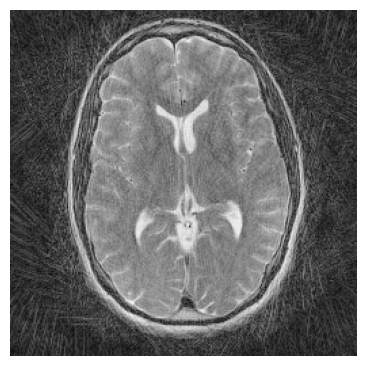

In [21]:
recon_NUFFT = op.nufft_recon(kdata, traj, sens_maps, dc_weights)
utils.imshow([recon_NUFFT], norm=0.5)

In [16]:
recons_gd, nmse_gd, grad_norm = op.nufft_gd_recon(gt, kdata, traj, sens_maps, iter=10)
recons_gd2, nmse_gd2, grad_norm2 = op.nufft_gd_recon(gt, kdata, traj, sens_maps, iter=10)
recons_gd3, nmse_gd3, grad_norm3 = op.nufft_gd_recon(gt, kdata, traj, sens_maps, iter=30)

  0%|          | 0/10 [00:00<?, ?iter/s]

  0%|          | 0/10 [00:00<?, ?iter/s]

  0%|          | 0/30 [00:00<?, ?iter/s]

In [ ]:
utils.imshow([i[-1] for i in [recons_gd, recons_gd2, recons_gd3]])

In [ ]:
utils.imshow(
    [gt, recon_NUFFT, recons_gd3[-1]],
    titles=["Ground Turth", "NUFFT", "Gradient Descent"],
    suptitle="Reconstructed images",
    norm=0.5,
)

In [ ]:
recons_gd, nmse_gd, grad_norm = op.nufft_gd_recon(gt, kdata, traj, sens_maps, iter=500)
f, a = plt.subplots(1, 2, figsize=(10, 5))

for i, (d, title) in enumerate(zip([nmse_gd, grad_norm], ["RMSE", "L2 Norm"])):
    a[i].plot(d)
    a[i].set_title(title)
    a[i].set_xlabel("Iteration")
    a[i].set_ylabel(title)

In [4]:
tol = 1e-4
maxit = 100
recon_cg, nmse_cg = op.cg_sense(
    kdata,
    traj,
    sens_maps,
    gt=gt,
    title=f"3_2-CG-SENSE(iter={maxit})",
)

  0%|          | 0/50 [00:00<?, ?iter/s]

In [ ]:
plt.plot(nmse_cg, label="CG-SENSE")
plt.plot(nmse_gd, label="GD")
plt.xlabel("Iteration")
plt.ylabel("NMSE")
plt.legend()
plt.show()

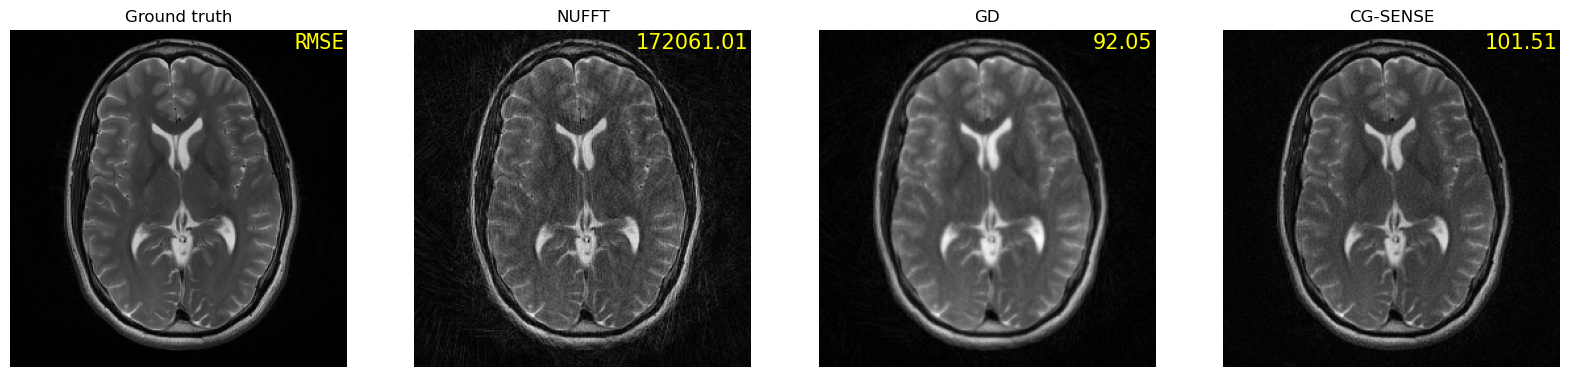

(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [28]:
utils.imshow(
    [recon_NUFFT, recons_gd[-1], recon_cg],
    gt=gt,
    titles=["NUFFT", "GD", "CG-SENSE"],
)
for item in  [recon_NUFFT, recons_gd[-1], recon_cg]:
    print(np.shape(item))
print(np.shape(gt))

In [21]:
op = Lab07_op()
kspace, sens_maps, traj, dc_weights, gt = op.load_data()

nufft_kdata = op.get_nufft_kdata(kspace)
nufft_traj = op.get_nufft_traj(traj)
nufft_sens = op.get_nufft_sens_maps(sens_maps)
im_size = [256,256]
grid_size = [512,512]
nufft_forward_operator = op.get_nufft_ob(im_size,grid_size)
nufft_adjoint_operator = op.get_nufft_adj_ob(im_size,grid_size)

x = torch.tensor(np.zeros([1,1,im_size[0],im_size[1]]),dtype=torch.complex128,device=op.device)
r = nufft_adjoint_operator(nufft_kdata,nufft_traj) - nufft_adjoint_operator(nufft_forward_operator(x,nufft_traj),nufft_traj)


print(np.shape(r))
print(r[0,1,0:5,0:5])


torch.Size([1, 4, 256, 256])
tensor([[0.1848-0.9313j, 0.1893-0.9210j, 0.1847-0.9216j, 0.1829-0.9280j,
         0.1757-0.9326j],
        [0.1799-0.9355j, 0.1890-0.9254j, 0.1894-0.9235j, 0.1863-0.9306j,
         0.1790-0.9343j],
        [0.1755-0.9384j, 0.1858-0.9297j, 0.1902-0.9233j, 0.1904-0.9312j,
         0.1833-0.9407j],
        [0.1710-0.9376j, 0.1875-0.9342j, 0.1920-0.9292j, 0.1950-0.9275j,
         0.1884-0.9398j],
        [0.1569-0.9444j, 0.1797-0.9360j, 0.1908-0.9371j, 0.1953-0.9332j,
         0.1920-0.9389j]], dtype=torch.complex128)


In [ ]:
recons_gd, nmse_gd, grad_norms = op.nufft_gd_recon(gt,kspace,traj,sens_maps)

(100, 256, 256)


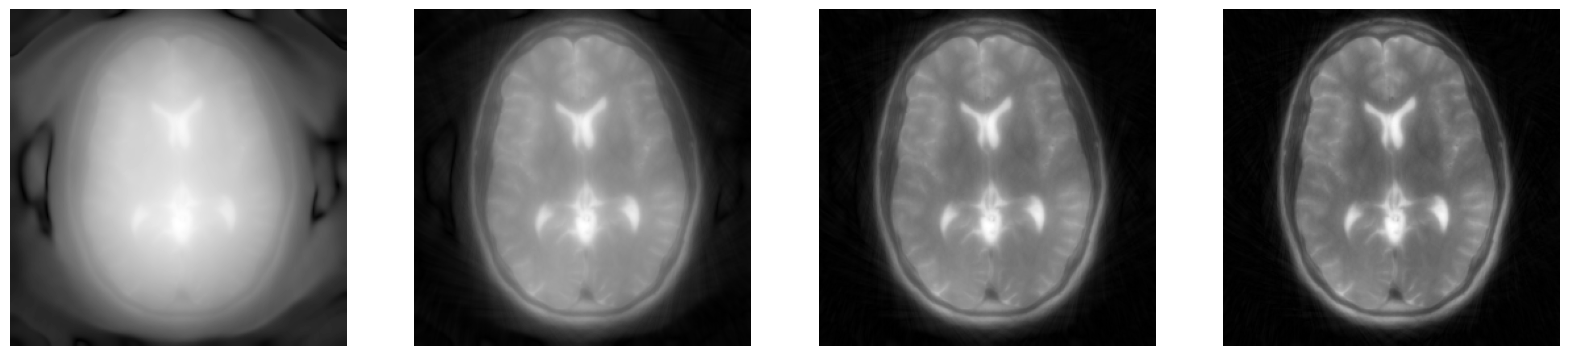

In [13]:
print(np.shape(recons_gd))
utils.imshow([recons_gd[0],recons_gd[25],recons_gd[50],recons_gd[75]])
utils.create_gif(recons_gd,title="gd_rec",duration=100)

In [ ]:
nufft_kdata = op.get_nufft_kdata(kspace)
nufft_traj = op.get_nufft_traj(traj)
nufft_sens = op.get_nufft_sens_maps(sens_maps)
im_size = [256,256]
grid_size = [512,512]
nufft_forward_operator = op.get_nufft_ob(im_size,grid_size)
nufft_adjoint_operator = op.get_nufft_adj_ob(im_size,grid_size)

ut = np.zeros([1,1,256,256],dtype=complex)
u = torch.tensor(ut,dtype=torch.complex128, device=op.device) 
g = op.get_nufft_kdata(kspace,dc_weights)
grad = op.calc_grad(nufft_forward_operator,nufft_adjoint_operator,nufft_traj,nufft_sens,u,g)

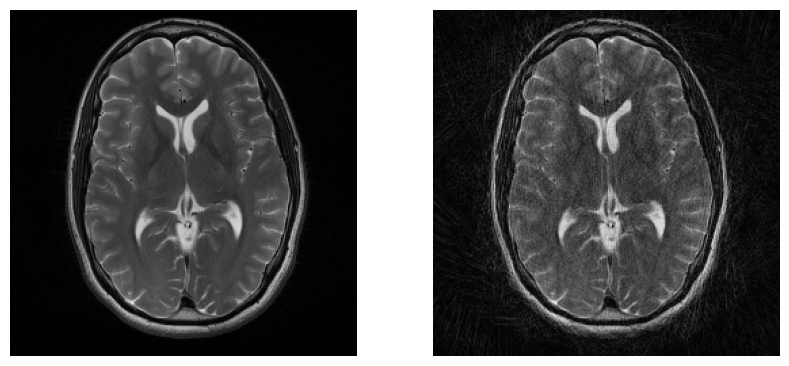

In [67]:
utils.imshow([gt,nufft_recon2])